In [7]:
import polars as pl
from inference import run_inference_transformers, load_peft_model
from utils import cache_dataframe, stories_dataset


@cache_dataframe("./data/stories_with_predictions.parquet")
def stories_with_predictions():
    stories = stories_dataset()

    mandt = load_peft_model("./models/stories_model_v2", merge=True)

    predictions = run_inference_transformers(stories["serialized"].to_list(), mandt)
    return stories.with_columns(pl.Series(name="predictions", values=predictions))


stories = stories_with_predictions()

stories = stories.with_columns(
    pl.Series(
        name="predicted_score", values=stories["predictions"].exp().cast(pl.Int64)
    )
)


In [8]:
import math


def calculate_metrics_by_split(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculate correlation and RMSE metrics for each split in the dataset.

    Args:
        df: DataFrame with log_score, predictions and split columns

    Returns:
        DataFrame with metrics for each split
    """
    metrics = []

    for split in df["split"].unique():
        split_df = df.filter(pl.col("split") == split)

        # Calculate baseline (mean) metrics
        average_score = split_df["log_score"].mean()
        rmse_baseline = math.sqrt(
            (split_df["log_score"] - average_score).pow(2).sum() / len(split_df)
        )

        # Calculate model metrics
        rmse_model = math.sqrt(
            (split_df["log_score"] - split_df["predictions"]).pow(2).sum()
            / len(split_df)
        )
        correlation_model = split_df.select(pl.corr("log_score", "predictions"))[
            "log_score"
        ][0]

        metrics.append(
            {
                "split": split,
                "baseline_rmse": rmse_baseline,
                "model_rmse": rmse_model,
                "model_correlation": correlation_model,
            }
        )

    return pl.DataFrame(metrics)


calculate_metrics_by_split(stories)

split,baseline_rmse,model_rmse,baseline_correlation,model_correlation
str,f64,f64,f64,f64
"""test""",1.334575,1.133601,NaN,0.529694
"""train""",1.324123,1.102933,NaN,0.555844
"""val""",1.323152,1.12773,NaN,0.524235


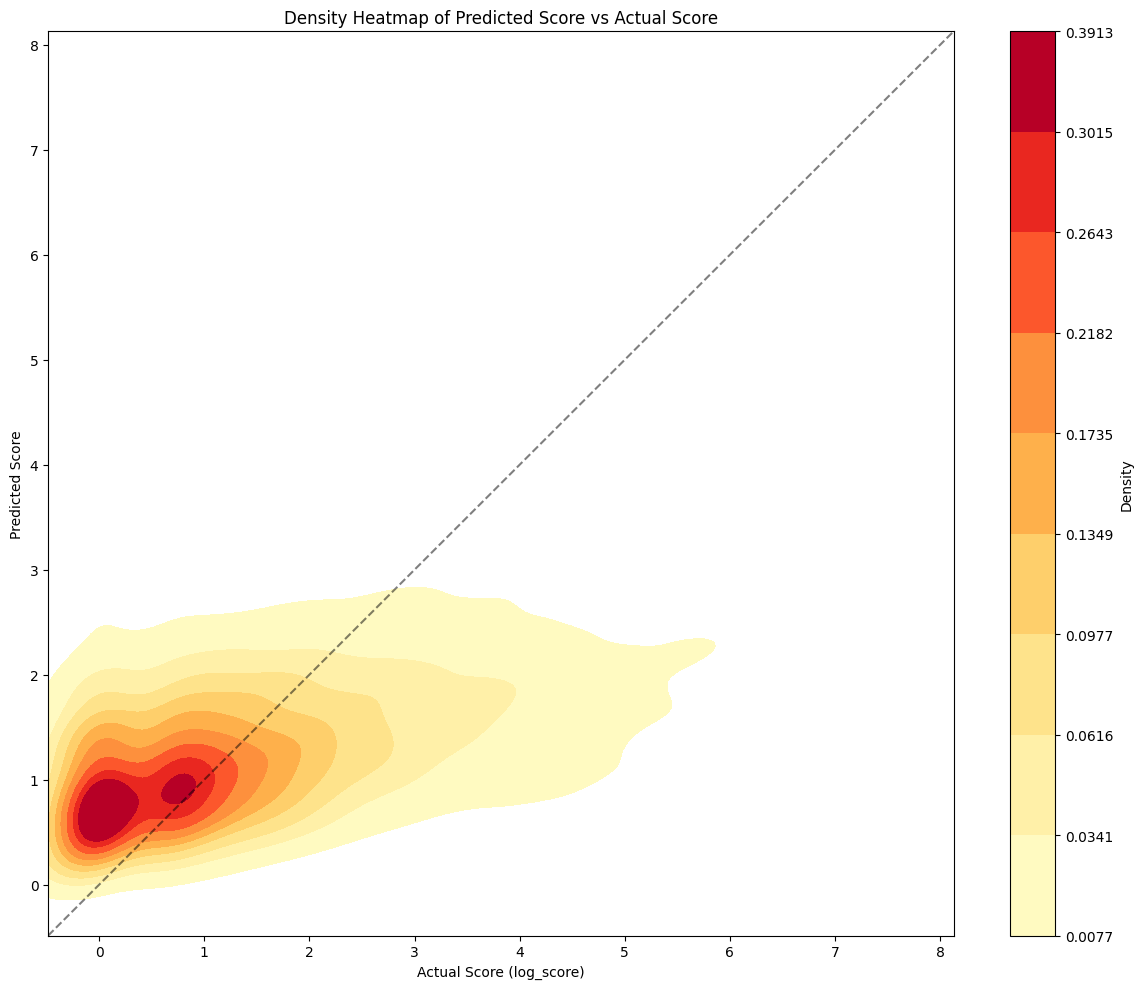

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the range for the heatmap
min_score = min(stories["log_score"].min(), stories["predictions"].min())
max_score = max(stories["log_score"].max(), stories["predictions"].max())

# Create a more continuous 2D histogram
plt.figure(figsize=(12, 10))
sns.kdeplot(
    data=stories.sample(10000, seed=42),
    x="log_score",
    y="predictions",
    cmap="YlOrRd",
    fill=True,
    cbar=True,
    cbar_kws={"label": "Density"},
)

plt.title("Density Heatmap of Predicted Score vs Actual Score")
plt.xlabel("Actual Score (log_score)")
plt.ylabel("Predicted Score")

# Set axis limits to match the data range
plt.xlim(min_score, max_score)
plt.ylim(min_score, max_score)

# Add a diagonal line for reference
plt.plot([min_score, max_score], [min_score, max_score], "k--", alpha=0.5)

plt.tight_layout()
plt.show()

In [10]:
stories = stories.sort("predicted_score", descending=True)

stories.select(pl.col("serialized", "predicted_score", "score"))

serialized,predicted_score,score
str,i64,i64
""" Ask HN: Who is hiring? (Octob…",624,678
""" Ask HN: Who is hiring? (Septe…",586,573
""" Ask HN: Who is hiring? (May 2…",534,553
""" Ask HN: Who is hiring? (Novem…",518,539
""" Ask HN: Who is hiring? (March…",502,592
…,…,…
""" Meet the Israeli startup that…",0,1
""" Irrfan Khan, Bhanu Athaiya Ge…",0,1
""" UnlockFame – You Have a Talen…",0,1


In [11]:
import os

stories = stories.with_columns(
    (pl.col("score") - pl.col("predicted_score")).alias("score_diff")
)

stories = stories.with_columns(
    pl.concat_str(
        pl.lit("https://news.ycombinator.com/item?id="),
        pl.col("id"),
    ).alias("link"),
)

os.makedirs("./data/sorted_stories", exist_ok=True)


# Function to save DataFrame to CSV
def save_to_csv(df, filename):
    df.select(
        pl.col("serialized", "predicted_score", "score", "score_diff", "link")
    ).write_csv(f"./data/sorted_stories/{filename}.csv")


# Top 100 stories by predicted score
top_100_predicted = stories.sort("predicted_score", descending=True).head(100)
save_to_csv(top_100_predicted, "top_100_predicted_score")

# Top 100 stories by actual score
top_100_actual = stories.sort("score", descending=True).head(100)
save_to_csv(top_100_actual, "top_100_actual_score")

# Bottom 100 stories by predicted score
bottom_100_predicted = stories.sort("predicted_score").head(100)
save_to_csv(bottom_100_predicted, "bottom_100_predicted_score")

# Top 100 stories by underperformance
top_100_underperform = stories.sort("score_diff").head(100)
save_to_csv(top_100_underperform, "top_100_underperform")

# Top 100 stories by overperformance
top_100_overperform = stories.sort("score_diff", descending=True).head(100)
save_to_csv(top_100_overperform, "top_100_overperform")

# Top 100 stories with highest predicted score but actual score of 1
top_100_predicted_score_1 = (
    stories.filter(pl.col("score") == 1)
    .sort("predicted_score", descending=True)
    .head(100)
)
save_to_csv(top_100_predicted_score_1, "top_100_predicted_score_actual_1")

print(
    "All subsets have been saved to CSV files in the ./data/sorted_stories directory."
)


All subsets have been saved to CSV files in the ./data/sorted_stories directory.


In [12]:
from utils import (
    cache_dataframe,
    stories_dataset,
)
from inference import run_inference_transformers, load_peft_model
import polars as pl


@cache_dataframe("./data/stories_with_predictions_sf.parquet")
def stories_with_predictions_sf():
    stories = stories_dataset()

    mandt = load_peft_model("./models/stories_model_schedulefree_v1", merge=True)

    predictions = run_inference_transformers(stories["serialized"].to_list(), mandt)
    return stories.with_columns(pl.Series(name="predictions", values=predictions))


stories = stories_with_predictions_sf()

stories = stories.with_columns(
    pl.Series(
        name="predicted_score", values=stories["predictions"].exp().cast(pl.Int64)
    )
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at unsloth/Meta-Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/35721 [00:01<10:31:47,  1.06s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 234.00 MiB. GPU 0 has a total capacity of 79.22 GiB of which 202.06 MiB is free. Process 2226597 has 32.55 GiB memory in use. Process 2262461 has 46.46 GiB memory in use. Of the allocated memory 30.92 GiB is allocated by PyTorch, and 994.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)